In [1]:
#importing all the necessary libraries.
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#importing the initial data from the file "Mallards_initial data.xlsx"
mallards=pd.read_excel("Mallards_initial data.xlsx")
#The line bellow is used for debugging.
mallards = mallards.loc[:, ~mallards.columns.str.contains('^Unnamed')]
print(mallards.tail(5))

       population  farmed       date       hour  slatitude  slongitude
19910         111       0 2012-10-03   18:46:46  56.440178   13.992034
19911         111       0 2012-10-03   19:46:42  56.439957   13.992407
19912         111       0 2012-10-03   20:47:04  56.440022   13.992071
19913         111       0 2012-10-03   21:49:33  56.440029   13.992332
19914         111       0 2012-10-03   22:48:59  56.440067   13.993050


In [3]:
# instead of any other type of grouping we choose to group the mallards by ordering them by population.
ordered = mallards.sort_values(by=["population"]).reset_index(drop=True)

In [4]:
ordered.tail(10)

,population,farmed,date,hour,slatitude,slongitude
19905,153,1,2012-10-19,04:39:28,56.500893,13.970902
19906,153,1,2012-10-19,05:39:21,56.500786,13.970841
19907,153,1,2012-10-19,06:38:23,56.500889,13.971055
19908,153,1,2012-10-19,07:38:58,56.487541,13.965097
19909,153,1,2012-10-19,08:39:03,56.487274,13.965044
19910,153,1,2012-10-19,09:39:15,56.487392,13.965101
19911,153,1,2012-10-19,10:38:33,56.487503,13.965265
19912,153,1,2012-10-19,11:38:27,56.487041,13.965001
19913,153,1,2012-10-18,07:41:34,56.487537,13.965165
19914,153,1,2012-10-08,07:59:45,56.432728,13.989956


In [5]:
#Saving the ordered by population data into the Excel file "mallards_ordered.xlsx"
ordered.to_excel("mallards_ordered.xlsx", index=False)

In [6]:
#Creating the dataframe that is going to be used as y. Each column will be used as y in a different model.
labelled = pd.DataFrame(columns=["dlatitude", "dlongitude"])

#Generating the labels by making the next coordinates as the destination coordinates for the previous row.
for i, row in ordered.iterrows():
    if i == ordered.index[-1]:
        break
    if row["population"] != ordered.iloc[i+1]["population"]:
        label_row = pd.DataFrame({"dlatitude": row["slatitude"], "dlongitude": row["slongitude"]}, index=[i])
    else:
        label_row = pd.DataFrame({"dlatitude": ordered.iloc[i+1]["slatitude"], "dlongitude": ordered.iloc[i+1]["slongitude"]}, index=[i])
    labelled = pd.concat([labelled, label_row])


In [7]:
labelled.head(10)

,dlatitude,dlongitude
0,56.439716,13.991791
1,56.440170,13.992670
2,56.440136,13.992191
3,56.441143,13.988527
4,56.439919,13.991972
5,56.439869,13.992161
6,56.439716,13.992242
7,56.439934,13.991963
8,56.439888,13.992043
9,56.440109,13.991787


In [8]:
# drop last two rows from ordered dataframe. It is used for data management.
ordered = ordered.iloc[:-2].reset_index(drop=True)

# drop last row from labelled dataframe. It is used for data management.
labelled = labelled.iloc[:-1].reset_index(drop=True)

In [9]:
print(ordered.iloc[:-1].shape)

(19912, 6)


In [10]:
print(labelled["dlatitude"].iloc[:-1].shape)

(19912,)


In [11]:
# Making different splits for different models, one for longitude and one latitude.
X_train, X_test, y_lat_train, y_lat_test = train_test_split(
    ordered.iloc[:-1], labelled["dlatitude"].iloc[:-1], test_size=0.2, random_state=42
)
X_train, X_test, y_long_train, y_long_test = train_test_split(
    ordered.iloc[:-1], labelled["dlongitude"].iloc[:-1], test_size=0.2, random_state=42
)

In [12]:
X_train.shape

(15929, 6)

In [13]:
# We use standard scaler to do our scalling, instead of manual scaling.
scaler = StandardScaler()

In [14]:
# Making sure that date and hour have the necessary format.
X_train_no_date = X_train.drop(['date', 'hour'], axis=1)
X_train_scaled = scaler.fit_transform(X_train_no_date)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_no_date.columns, index=X_train_no_date.index)
X_train_scaled_df[['date', 'hour']] = X_train[['date', 'hour']]

In [15]:
# Making sure that date and hour have the necessary format.
X_test_no_date = X_test.drop(['date', 'hour'], axis=1)
X_test_scaled = scaler.transform(X_test_no_date)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_no_date.columns, index=X_test_no_date.index)
X_test_scaled_df[['date', 'hour']] = X_test[['date', 'hour']]

In [16]:
# extract day of the week and hour of the day from datetime columns
X_train_scaled_df['weekday'] = X_train_scaled_df['date'].dt.weekday
X_train_scaled_df['hour'] = pd.to_datetime(X_train_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_train_scaled_df['hour'] = X_train_scaled_df['hour'].dt.hour

X_test_scaled_df['weekday'] = X_test_scaled_df['date'].dt.weekday
X_test_scaled_df['hour'] = pd.to_datetime(X_test_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_test_scaled_df['hour'] = X_test_scaled_df['hour'].dt.hour

X_train_scaled_df['weekday_sin'] = np.sin(2 * np.pi * X_train_scaled_df['weekday'] / 7)
X_train_scaled_df['weekday_cos'] = np.cos(2 * np.pi * X_train_scaled_df['weekday'] / 7)

X_train_scaled_df['hour_sin'] = np.sin(2 * np.pi * X_train_scaled_df['hour'] / 24)
X_train_scaled_df['hour_cos'] = np.cos(2 * np.pi * X_train_scaled_df['hour'] / 24)

X_test_scaled_df['weekday_sin'] = np.sin(2 * np.pi * X_test_scaled_df['weekday'] / 7)
X_test_scaled_df['weekday_cos'] = np.cos(2 * np.pi * X_test_scaled_df['weekday'] / 7)

X_test_scaled_df['hour_sin'] = np.sin(2 * np.pi * X_test_scaled_df['hour'] / 24)
X_test_scaled_df['hour_cos'] = np.cos(2 * np.pi * X_test_scaled_df['hour'] / 24)


X_train_scaled_df = X_train_scaled_df.drop(['weekday', 'hour', 'date'], axis=1)
X_test_scaled_df = X_test_scaled_df.drop(['weekday', 'hour', 'date'], axis=1)

In [17]:
X_train_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,weekday_sin,weekday_cos,hour_sin,hour_cos
11284,0.030042,-0.524242,0.125260,0.133639,-0.974928,-0.222521,-0.707107,7.071068e-01
11964,0.138355,-0.524242,0.127363,0.126657,0.000000,1.000000,-0.965926,2.588190e-01
5390,-0.879784,-0.524242,0.125449,0.134608,-0.433884,-0.900969,-0.707107,-7.071068e-01
860,-1.356359,-0.524242,0.124414,0.135708,0.974928,-0.222521,-1.000000,-1.836970e-16
15795,0.939869,-0.524242,0.125983,0.133088,0.000000,1.000000,0.707107,7.071068e-01


In [18]:
X_test_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,weekday_sin,weekday_cos,hour_sin,hour_cos
16564,1.113169,1.907515,0.123946,0.131636,-0.433884,-0.900969,-0.707107,0.707107
19327,1.849695,1.907515,-4.781471,-1.732344,0.000000,1.000000,0.500000,-0.866025
15022,0.874881,-0.524242,0.126517,0.128668,0.433884,-0.900969,0.000000,1.000000
2457,-1.139734,-0.524242,0.124135,0.135700,0.781831,0.623490,0.965926,0.258819
9210,-0.229908,-0.524242,0.121909,0.135181,-0.974928,-0.222521,-0.965926,-0.258819


In [19]:
#Important part of the code. it is the place where we set our configuration.
n_units = 32
activation = 'relu'
loss_function = 'mean_squared_error'

In [20]:
# A separate model to detect latitude.
modelLat = Sequential()
modelLat.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLat.add(Dense(1))
modelLat.compile(optimizer='adam', loss=loss_function)

In [21]:
# A separate model to detect longitude.
modelLong = Sequential()
modelLong.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLong.add(Dense(1))
modelLong.compile(optimizer='adam', loss=loss_function)

In [22]:
print(X_train_scaled_df.values.shape)

(15929, 8)


In [23]:
print(y_lat_train.values.shape)

(15929,)


In [24]:
print(modelLat.input_shape)

(None, 8)


In [25]:
print(modelLong.input_shape)

(None, 8)


In [26]:
X_train_scaled_df.shape

(15929, 8)

In [27]:
X_test_scaled_df.shape

(3983, 8)

In [28]:
# Fitting the data in the model for latitude.
historyLat=modelLat.fit(X_train_scaled_df.values, y_lat_train, validation_data=(X_test_scaled_df.values, y_lat_test), epochs=1000)

Epoch 1/1000
498/498 [==============================] - 2s 4ms/step - loss: 2399.6782 - val_loss: 1370.3243
Epoch 2/1000
498/498 [==============================] - 1s 3ms/step - loss: 555.0521 - val_loss: 110.4352
Epoch 3/1000
498/498 [==============================] - 1s 2ms/step - loss: 42.5644 - val_loss: 20.2142
Epoch 4/1000
498/498 [==============================] - 1s 2ms/step - loss: 15.0425 - val_loss: 11.2587
Epoch 5/1000
498/498 [==============================] - 1s 3ms/step - loss: 8.4733 - val_loss: 6.3912
Epoch 6/1000
498/498 [==============================] - 1s 2ms/step - loss: 4.8550 - val_loss: 3.8730
Epoch 7/1000
498/498 [==============================] - 1s 2ms/step - loss: 3.0316 - val_loss: 2.6029
Epoch 8/1000
498/498 [==============================] - 1s 1ms/step - loss: 2.0947 - val_loss: 1.8944
Epoch 9/1000
498/498 [==============================] - 1s 1ms/step - loss: 1.5436 - val_loss: 1.4479
Epoch 10/1000
498/498 [==============================] - 1s 1ms/step

498/498 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.2308
Epoch 81/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.2283
Epoch 82/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.2254
Epoch 83/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.2237
Epoch 84/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.2172
Epoch 85/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.2132
Epoch 86/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.2112
Epoch 87/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.2095
Epoch 88/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.2065
Epoch 89/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0055 - v

498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0489
Epoch 160/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0533
Epoch 161/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0455
Epoch 162/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0448
Epoch 163/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0434
Epoch 164/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0468
Epoch 165/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0414
Epoch 166/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0404
Epoch 167/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0428
Epoch 168/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0064
Epoch 239/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0063
Epoch 240/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0064
Epoch 241/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0058
Epoch 242/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 243/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0081
Epoch 244/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0072
Epoch 245/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 246/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0074
Epoch 247/1000
498/498 [==============================] - 1s 1ms

498/498 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 317/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 318/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 319/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 320/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 321/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 322/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 323/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 324/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 325/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

Epoch 395/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 396/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 397/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 398/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 399/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 400/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 401/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 402/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 403/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 404/1000
498/498 [==============================] - 1s 1ms

498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 474/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 475/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 476/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 477/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0238
Epoch 478/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 479/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 480/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 481/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 482/1000
498/498 [==============================] - 1s 1ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0016A: 0s - loss: 0
Epoch 552/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 553/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 554/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 555/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 556/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 557/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 9.0534e-04
Epoch 558/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 559/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 560/1000
498/498 [==============================] - 1s

Epoch 628/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 629/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 630/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 631/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 632/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 8.0815e-04
Epoch 633/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 8.8919e-04
Epoch 634/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 635/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0035 - val_loss: 9.0015e-04
Epoch 636/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 637/1000
498/498 [============================

Epoch 706/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 707/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 708/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 709/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0019s - loss: 0.
Epoch 710/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 711/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 712/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 713/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 714/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 715/1000
498/498 [============================

498/498 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 785/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 786/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 787/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 788/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 789/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 790/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 791/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 792/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0013s - loss
Epoch 793/1000
498/498 [==============================] - 1s 2ms/step -

498/498 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 863/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 864/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 865/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 866/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 867/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 868/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 869/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 870/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 871/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 941/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 942/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 943/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 944/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 945/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 946/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 947/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 948/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 949/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

In [29]:
# Fitting the data in the model for latitude.
historyLong=modelLong.fit(X_train_scaled_df.values, y_long_train, validation_data=(X_test_scaled_df.values, y_long_test), epochs=1000)

Epoch 1/1000
498/498 [==============================] - 1s 2ms/step - loss: 85.3600 - val_loss: 5.9948
Epoch 2/1000
498/498 [==============================] - 1s 2ms/step - loss: 1.5130 - val_loss: 0.5832
Epoch 3/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.3866 - val_loss: 0.2485
Epoch 4/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.1877 - val_loss: 0.1454
Epoch 5/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.1168 - val_loss: 0.1001
Epoch 6/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0827 - val_loss: 0.0772
Epoch 7/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0646 - val_loss: 0.0631
Epoch 8/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0528 - val_loss: 0.0541
Epoch 9/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0439 - val_loss: 0.0485
Epoch 10/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.03

498/498 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0100
Epoch 77/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0105
Epoch 78/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 79/1000
498/498 [==============================] - ETA: 0s - loss: 0.005 - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0094
Epoch 80/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 81/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0088
Epoch 82/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0090
Epoch 83/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0087
Epoch 84/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0143
Epoch 85/1000
498/498 [==============================] - 1s 3ms

498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 155/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 156/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0090
Epoch 157/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 158/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 159/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 160/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 161/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 162/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 163/1000
498/498 [==============================] - 1s 3ms/step - loss: 0

Epoch 232/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 233/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 234/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 235/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0094
Epoch 236/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 237/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0079
Epoch 238/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 239/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 240/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 241/1000
498/498 [==============================] - 1s 2ms

Epoch 310/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0074
Epoch 311/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 312/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 313/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 314/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 315/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 316/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 317/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 318/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 319/1000
498/498 [==============================] - 1s 2ms

498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 389/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 390/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 391/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 392/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 393/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 394/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 395/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 396/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 397/1000
498/498 [==============================] - 1s 3ms/step - loss: 0

498/498 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 467/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 468/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 469/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 470/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 471/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 472/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 473/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 474/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 475/1000
498/498 [==============================] - 1s 3ms/step - loss: 0

498/498 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0021 0s - loss: 0.0
Epoch 545/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 546/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0024A: 0s - loss
Epoch 547/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 548/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 549/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 550/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 551/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 552/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 553/1000
498/498 [============================

498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 622/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 623/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 624/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 625/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 626/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 627/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 628/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 629/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 630/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 700/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 701/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 702/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 703/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0041 0s - loss: 0.004
Epoch 704/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 705/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 706/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 707/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 708/1000
498/498 [==============================] - 1s 2

498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 778/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 779/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 780/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 781/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0051
Epoch 782/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 783/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 784/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 785/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 786/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0024 0s - loss:
Epoch 855/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0028TA: 0s - loss: 0. - ETA: 0s - loss: 0.0
Epoch 856/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 857/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0022 - ETA: 0s - loss: 0.004
Epoch 858/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0030s - loss: 0.0
Epoch 859/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 860/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 861/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 862/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss:

498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 932/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 933/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0023 0s - loss: 0.00
Epoch 934/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 935/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 936/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 937/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 938/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 939/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 940/1000
498/498 [==============================] - 1s 2m

In [30]:
# Predict the Longitude values for the test set
y_long_pred = modelLong.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_long_test, y_long_pred)
rmse = mean_squared_error(y_long_test, y_long_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.015102506843522831
Root Mean Squared Error (RMSE): 0.047979877606940655


In [31]:
# Predict the Latitude values for the test set
y_lat_pred = modelLat.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_lat_test, y_lat_pred)
rmse = mean_squared_error(y_lat_test, y_lat_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.038248616113416095
Root Mean Squared Error (RMSE): 0.061632094677201606


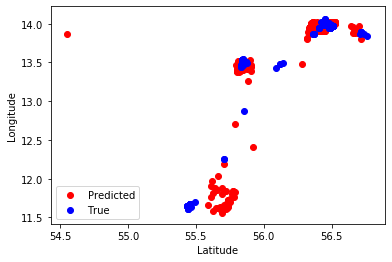

In [50]:
# create scatter plot
plt.scatter(y_lat_pred, y_long_pred, c='r', label='Predicted')
plt.scatter(y_lat_test, y_long_test, c='b', label='True')

# add labels and legend
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

# show plot
plt.show()

In [33]:
X_test["population"].shape

(3983,)

In [34]:
y_lat_test_comb = pd.DataFrame(y_lat_test)
y_lat_test_comb.shape

(3983, 1)

In [35]:
y_long_test_comb = pd.DataFrame(y_long_test)
y_long_test_comb.shape

(3983, 1)

In [36]:
y_lat_pred_comb = pd.DataFrame(y_lat_pred)
y_lat_pred_comb.shape

(3983, 1)

In [37]:
y_long_pred_comb = pd.DataFrame(y_long_pred)
y_long_pred_comb.shape

(3983, 1)

In [38]:
pop_df = pd.DataFrame(X_test["population"].values.reshape(-1, 1))
pop_df.shape

(3983, 1)

In [39]:
# Create a dataframe with all the values, (predicted and actual), in order to be used for diagrams and comparisons.
combined_df = pd.concat([pop_df, y_lat_pred_comb, y_long_pred_comb, y_lat_test_comb, y_long_test_comb], axis=1)
combined_df.columns = ["population", "Pred_latitude", "Pred_longitude", "latitude", "longitude"]

In [40]:
combined_df = combined_df.dropna()

In [41]:
combined_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
0,71.0,56.457363,14.005986,56.439716,13.991791
3,88.0,56.418926,13.979908,56.441143,13.988527
6,131.0,56.436947,13.987967,56.439716,13.992242
17,27.0,56.486874,14.003541,56.439903,13.992476
19,23.0,56.492275,13.996119,56.439484,13.992446
31,67.0,56.464821,13.998818,56.439350,13.992638
34,24.0,56.476257,13.997991,56.440166,13.992716
35,131.0,56.424179,13.981995,56.439930,13.992993
41,152.0,56.348122,13.956520,56.440140,13.992735
42,152.0,56.367508,13.943621,56.440044,13.992678


In [42]:
#selecting the most frequent population of the populations that have more than 20 members.
threshold = 20
populations_above_threshold = combined_df['population'].value_counts()[combined_df['population'].value_counts() >= threshold].index
if len(populations_above_threshold) > 0:
    most_frequent_pop = combined_df.loc[combined_df['population'].isin(populations_above_threshold)]['population'].value_counts().idxmax()
    most_frequent_pop_df = combined_df.loc[combined_df['population'] == most_frequent_pop]
else:
    print("change the threshold!")


In [43]:
most_frequent_pop_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
41,152.0,56.348122,13.956520,56.440140,13.992735
42,152.0,56.367508,13.943621,56.440044,13.992678
181,152.0,56.365543,13.949449,56.440220,13.992155
218,152.0,56.358944,13.945729,56.440342,13.992517
257,152.0,55.880062,13.260110,56.439884,13.991575
449,152.0,56.336632,13.921861,56.439644,13.992051
466,152.0,56.369106,13.965182,56.439968,13.992618
836,152.0,56.364216,13.953240,56.439949,13.992587
1010,152.0,56.375282,13.929629,56.439953,13.993013
1063,152.0,56.345982,13.950933,56.439720,13.992579


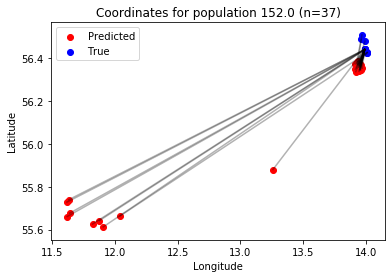

In [44]:
# Filter for rows with non-null predicted and true coordinates
filtered_df = most_frequent_pop_df.dropna(subset=['Pred_latitude', 'Pred_longitude', 'latitude', 'longitude'])

# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()


In [45]:
most_frequent_pop_df.shape

(37, 5)

In [46]:
# Removing outliers
filtered_df = filtered_df[(filtered_df['Pred_longitude'] >= 13.7) & (filtered_df['longitude'] >= 13.7)]

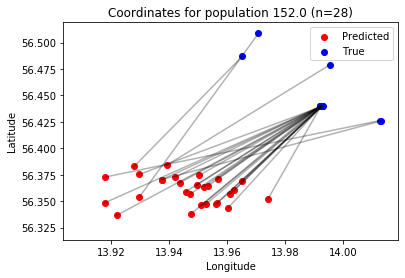

In [47]:
# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()

In [48]:
# Removing outliers
combined_df = combined_df[(combined_df['Pred_longitude'] >= 13.7) & (combined_df['longitude'] >= 13.7)]

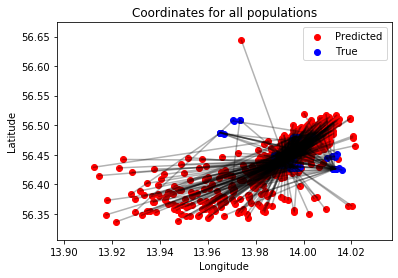

In [49]:
# Create scatter plot of predicted and true coordinates
plt.scatter(combined_df['Pred_longitude'], combined_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(combined_df['longitude'], combined_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in combined_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for all populations")

# Show plot
plt.show()